# MIE 1624 Introduction to Data Anaytics

# Course Project- Fake News Detection


## Group 8 
1.Kunal Bambardekar (1005618002)
<br>
2.Renu Indapurkar (1005659039)
<br>
3.Amir Mohammad (999593079)
<br>
4.Rafael Perez (1006594641)
<br>
5.Collin Wilson (1002258175)

---

In the 'Fake News Detection' project we seek to explore if certain words or combinations of them help us predict the truthfulness of associated claim? For this purpose, following steps are performed and the methodology and results are discussed in respective sections

## Procedure
1. Data Cleaning
2. Preliminary data analysis
3. Model preparation
4. Model implementation with model tuning
5. Visualizing Models Results

In [1]:
#Installing packages


#!pip install json
#!pip install numpy
#!pip install pandas
#!pip install nltk
#!pip install sklearn
#nltk.download('wordnet')    
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

In [2]:
#Importing necessary libraries


import json
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Defining a lemmatizer function to clean data later
lemmatizer = WordNetLemmatizer()

f = open("stop_words.txt", "r")
stop_words = f.read().split('\n')

## Data Importing

In [4]:
with open('train.json', 'r') as myfile:
    data=myfile.read()
    
obj = json.loads(data)

In [5]:
claim = [s['claim'] for s in obj]
claimant = [s['claimant'] for s in obj]
date = [s['date'] for s in obj]
articles = [s['related_articles'] for s in obj]
label = [s['label'] for s in obj]
claim_id = [s['id'] for s in obj]

#del data, obj

## <u> Step 1.  Data Cleaning</u>

Web-scraped data often contains html characters and punctuation symbols that do not affect the meaning of a sentence.It also consists of various forms of a single word. Hence data cleaning techniques such as lemmatizing and stemming are used. What this does is stem plurals to their singular form (eg. cats to cat) and verbs to their roots (eg. played to play), amongst other things. Data cleaning also includes converting the text into lower case and removing of words that have no impact on the sentiment of the text known as 'stop words'. 'nltk' library is used for data cleaning with the help of various functions as mentioned in the following section.

In [6]:
def get_wordnet_pos(w):
    ''' input: word (string)
    output: part-of-speech of word
    '''
    pos = nltk.pos_tag([w])[0][1][0].upper()
    pos_dict = {"J": wordnet.ADJ,"N": wordnet.NOUN,"V": wordnet.VERB,"R": wordnet.ADV}
    return pos_dict.get(pos, wordnet.ADV)

def clean_text(s):
    '''input: sentence
    output: cleaned version of sentence
    lower case + lemmatization + stop word removal + punctuation filtering
    '''
    
    global stop_words
    global lemmatizer
    
    no_space = '!."#$%&()*,/:;?@[\\]^_`{|}~0123456789'
    with_space = '-+<=>\n\t\v\b'
        
    # convert to lower-case
    s = str.lower(s)
    
    # replace special apostrophes with the typical '
    s = s.replace('‘', "'").replace('’', "'").replace('“', "'").replace('”', "'")
    
    # replace numbers and punctuation characters with spaces
    for char in with_space: s = s.replace(char, ' ')
    for char in no_space: s = s.replace(char, '')
    
    # stop word removal
    s = ' '.join([w for w in s.split(' ') if w not in stop_words])
    
    # remove remaining apostrophes
    s = s.replace('\'', '')
    
    s = nltk.word_tokenize(s)
    # lemmatize words    
    s = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in s]
    
    # remove isolated characters if any
    s = [w for w in s if len(w)>1]
    
    # an additional check for stop words
    s = ' '.join([w for w in s if w not in stop_words])
    
    return s

In [7]:
#printing the cleaned data
claim = [clean_text(s['claim']) for s in obj]
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=claim).head(10)

,0
0,george orwell novel predicts power smartphones
1,maine legislature candidate leslie gibson insult parkland shoot survivor activist emma gonzalez twitter
2,year girl alyssa carson train nasa astronaut
3,author roald dahl pen open letter urge parent child vaccinate measles
4,fight terrorism thing work base lot empirical evidence torture
5,rhode island dead northeastern state length time degree murderer spend prison eligible parole
6,poorest county appalachia happen percent white
7,koch industry paid legal fee george zimmerman
8,minnesota michigan iowa mph speed limit rural interstate safely
9,fbi uniform crime report time people stabbed death kill rifle kind


---
###  File with the cleaned data
With the aim of reducing computational time:
1. During the development of the project the data was cleaned and exported to a file called cleaned_data.csv.
2. In successive runs of the code the use of such file, cleaned_data.csv, avoided time losses re-cleaning the data.
3. The file is included with the submitted documents.

In [8]:

#importing file with the cleaned data

data = pd.read_csv('cleaned_data.csv')
data = data.drop(columns=data.columns[0])
label = list(data['label'])
claim = list(data['claim'])
claim_id = list(data['id'])

---

In [9]:
pd.set_option('display.max_colwidth', -1)
data.head()

,id,claim,label
0,0,george orwell novel predicts power smartphones,0
1,1,maine legislature candidate leslie gibson insult parkland shoot survivor activist emma gonzalez twitter,2
2,4,year girl alyssa carson train nasa astronaut,1
3,5,author roald dahl pen open letter urge parent child vaccinate measles,2
4,6,fight terrorism thing work base lot empirical evidence torture,2


In [10]:
#Labeling the claims with label=0 as 'false' 
words = np.unique([item for sublist in [s.split(' ') for s in data['claim'][data['label'] == 0]] for item in sublist], 
                  return_counts=True)

df_false = pd.DataFrame(data=words[0], columns=['word'])
df_false['count'] = words[1]
df_false['label'] = 'false'
df_false = df_false.sort_values('count', axis=0, ascending=False).head(30)

In [11]:
#Labeling the claims with label=1 as 'Partly true' 
words = np.unique([item for sublist in [s.split(' ') for s in data['claim'][data['label'] == 1]] for item in sublist], 
                  return_counts=True)

df_ptrue = pd.DataFrame(data=words[0], columns=['word'])
df_ptrue['count'] = words[1]
df_ptrue['label'] = 'partly true'
df_ptrue = df_ptrue.sort_values('count', axis=0, ascending=False).head(30)

In [12]:
#Labeling the claims with label=2 as 'true' 
words = np.unique([item for sublist in [s.split(' ') for s in data['claim'][data['label'] == 2]] for item in sublist], 
                  return_counts=True)

df_true = pd.DataFrame(data=words[0], columns=['word'])
df_true['count'] = words[1]
df_true['label'] = 'true'
df_true = df_true.sort_values('count', axis=0, ascending=False).head(30)

---
## <u> Step 2. Preliminary Data Analysis</u>

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites. WordCloud() function is used for this purpose
Following are the three word clouds presented for 'false', 'partly true' and 'true' claims. Along with the same, based on the word cloud most dominated words are represented in the bar graph with their count in 'true', 'partly true' and 'false' claims

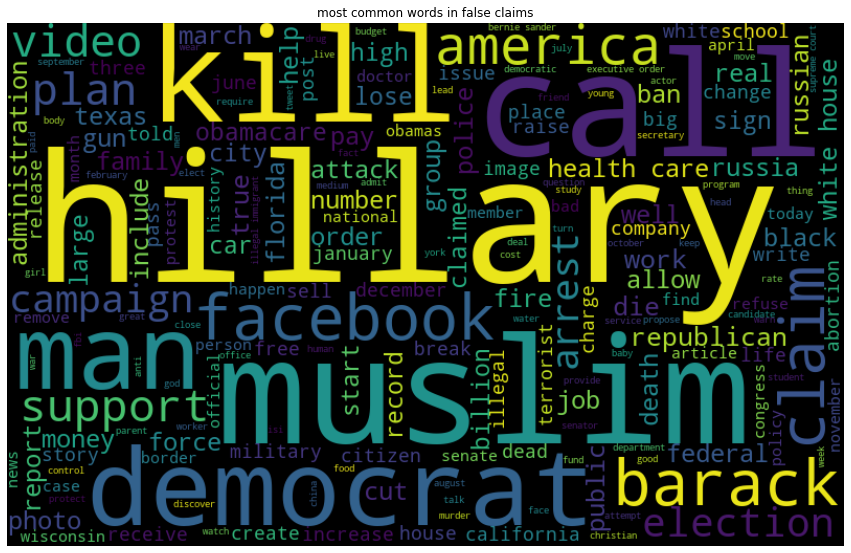

In [13]:
#WordCloud for false claims
from wordcloud import WordCloud
stopwords = set(df_false['word']).intersection(set(df_true['word']).union(set(df_ptrue['word'])))
s = ' '.join(list(data['claim'][data['label'] == 0].fillna('')))
wordcloud = WordCloud(width=800, height=500, random_state=0, stopwords=stopwords).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('most common words in false claims')
plt.axis('off')
plt.show()

Visualized words that tend to mostly be in false claims. It looks like claims about Hillary Clinton, Muslims, Barack Obama and the Democrats tend to be false

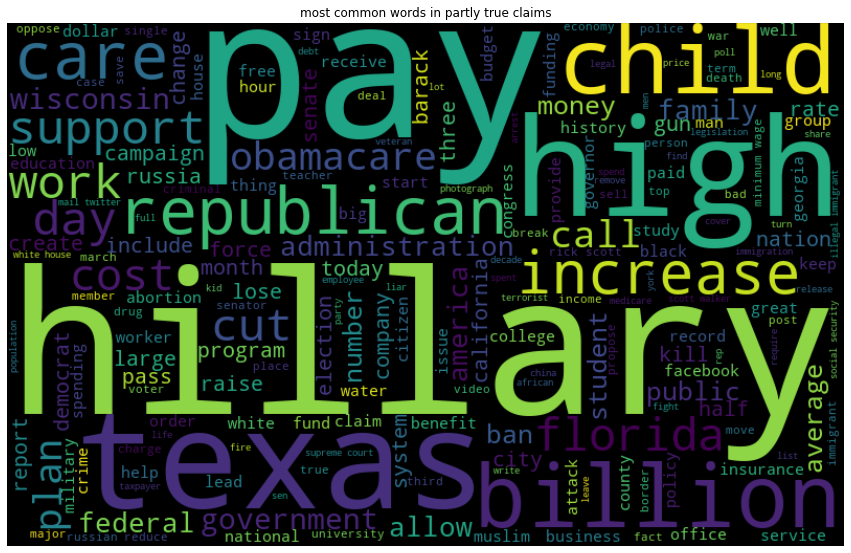

In [14]:
#Wodcloud for partly true claims
stopwords = set(df_ptrue['word']).intersection(set(df_true['word']).union(set(df_false['word'])))
s = ' '.join(list(data['claim'][data['label'] == 1].fillna('')))
wordcloud = WordCloud(width=800, height=500, random_state=0, stopwords=stopwords).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('most common words in partly true claims')
plt.axis('off')
plt.show()

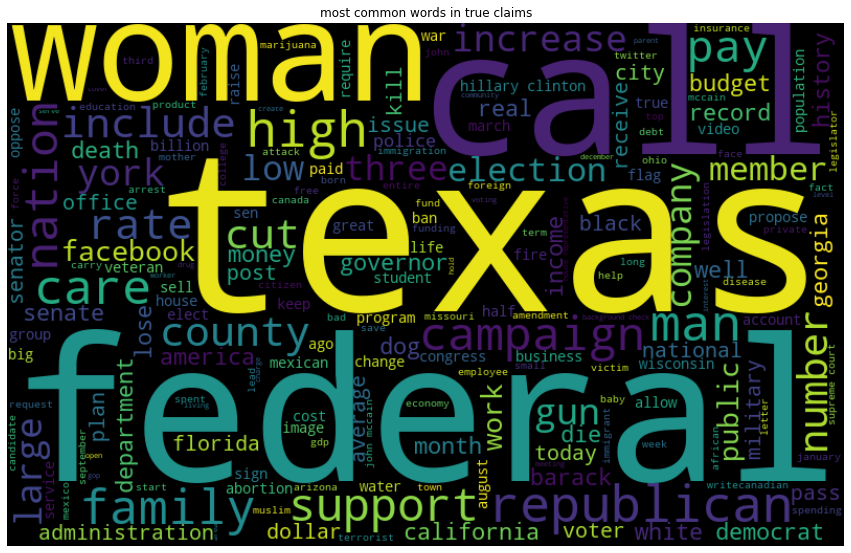

In [15]:
#Wordcloud for true claims
stopwords = set(df_true['word']).intersection(set(df_false['word']).union(set(df_ptrue['word'])))
s = ' '.join(list(data['claim'][data['label'] == 2].fillna('')))
wordcloud = WordCloud(width=800, height=500, random_state=0, stopwords=stopwords).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('most common words in true claims')
plt.axis('off')
plt.show()

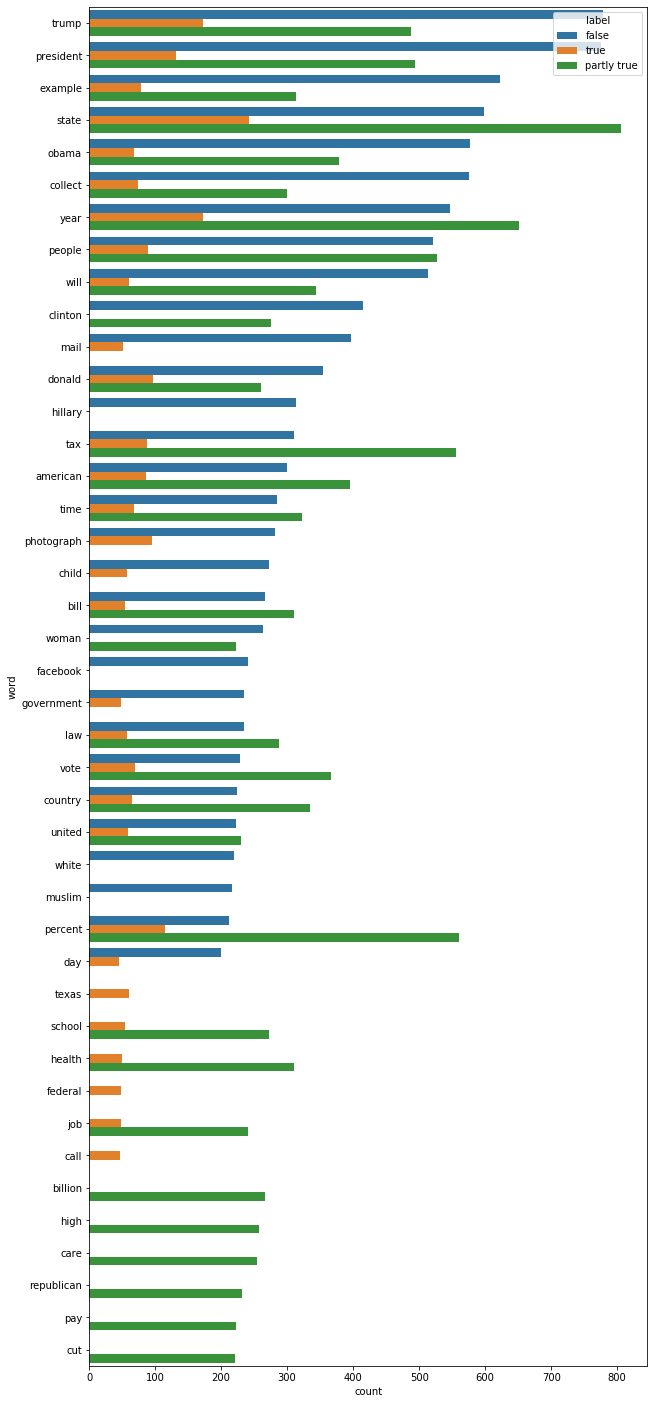

In [16]:
#plotting bar graph showing frequency of each word with  respect to false, true and partly true claims
plt.figure(figsize=(10, 25))
sns.barplot(y='word', x='count', data=df_false.append(df_true).append(df_ptrue), hue='label')
plt.show()

In [17]:
# Defining a function that plots counts and set a graph
def count_plot(dataframe, column,a=['title', 'x', 'y']):
    fig, (ax1) = plt.subplots(1, figsize=(14,8))
    sns.countplot(y=column, data=dataframe)
    plt.title("%s" %(a[0]))
    plt.xlabel("%s" %(a[1]))
    plt.ylabel("%s" %(a[2]))
    plt.show()

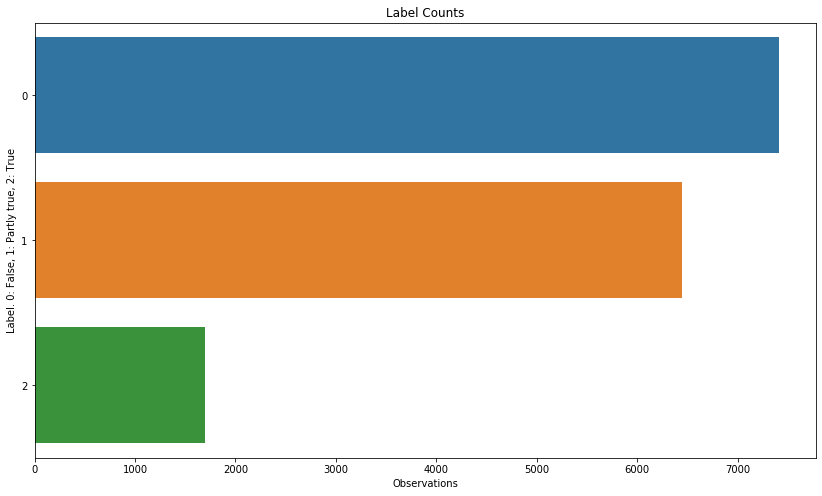

In [18]:
count_plot(data,data['label'], ['Label Counts','Observations','Label. 0: False, 1: Partly true, 2: True'] )

Label of Claims: There are almos 5 times more False claim (news) than true ones. In general Partly true and false news are

In [19]:
def create_feat(dataframe, column):
    #### length of the text
    dataframe["length"] = column.str.len()
    #### splitting into words, and counting # of words
    dataframe["words"] = column.str.split()
    dataframe["words_number"] = dataframe["words"].str.len()
    #### average word lenght
    dataframe['word_ave_len'] = dataframe["length"] / dataframe["words_number"]

In [20]:
create_feat(data, data['claim'])

In [21]:
def dist_plot(dataframe, column,a=['title', 'x']):
    fig, (ax1) = plt.subplots(1, figsize=(14,8))
    sns.distplot(column)
    plt.title("%s" %(a[0]))
    plt.xlabel("%s" %(a[1]))
    plt.ylabel('Frequency')
    plt.show()

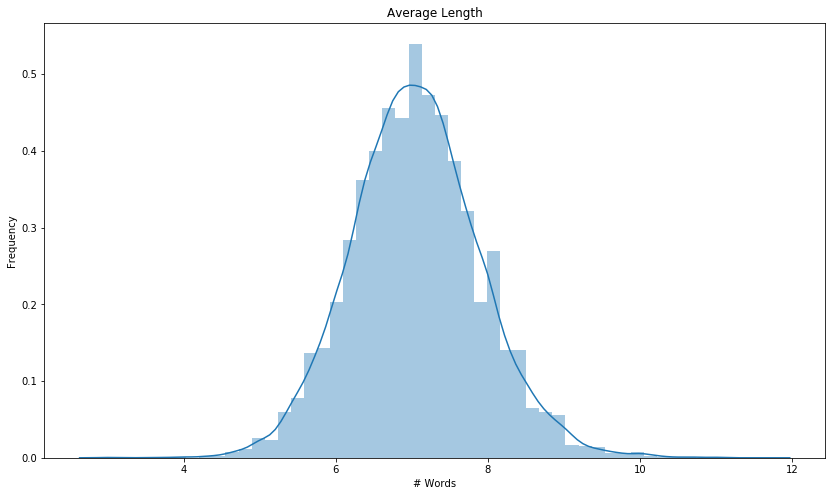

In [22]:
dist_plot(data, data['word_ave_len'],['Average Length', '# Words'])

The length of claims after cleaning is now more or less normally distributed around a center of 7 words

##  <u> Step 3. Model Preparation</u>
    
7 ML models were tested and tuned in the research using 3 methods of encoding the data numerically namely bag-of-words, n-grams, TF, and TD-IDF. 

In [23]:
# Bag of words / N-grams
def bag_of_words(min_count=5, min_g=1, max_g=1):
    ''' returns a matrix whose columns are features (words/n-grams) and rows 
    are recurrences of feature in each instance.
    input:
        min_count: the minimum sum of recurrences for the feature
        min_g: n-gram lower number
        max_g: n-gram higher number
    output:
        X: dataframe object of encoded data
    '''
    global claim
    
    vectorizer = CountVectorizer(ngram_range=(min_g, max_g), 
                                 min_df=min_count/len(claim), max_df=0.6)
    X = vectorizer.fit_transform(claim)
    
    X = pd.DataFrame(data=X.toarray(), 
                     columns=vectorizer.get_feature_names(), index=claim_id)
    return X

# TF-IDF
def tf_idf(min_count=5, min_g=1, max_g=1):
    ''' returns a matrix whose columns are features (words/n-grams) and rows 
    are tf-idf values of feature in each instance.
    input:
        min_count: the minimum sum of recurrences for the feature
        min_g: n-gram lower number
        max_g: n-gram higher number
    output:
        X: dataframe object of encoded data
    '''
    global claim
    
    vectorizer = TfidfVectorizer(ngram_range=(min_g, max_g), 
                                 min_df=min_count/len(claim), max_df=0.6)
    X = vectorizer.fit_transform(claim)
    
    X = pd.DataFrame(data=X.toarray(), 
                     columns=vectorizer.get_feature_names(), index=claim_id)
    return X

# TF
def term_freq(min_count=5, min_g=1, max_g=1):
    ''' returns a matrix whose columns are features (words/n-grams) and rows 
    are frequencies of feature in each instance.
    (advise: use min_g=max_g=1 for fast run time)
    input:
        min_count: the minimum sum of recurrences for the feature
        min_g: n-gram lower number
        max_g: n-gram higher number
    output:
        X: dataframe object of encoded data
    '''
    global claim
    
    vectorizer = CountVectorizer(ngram_range=(min_g, max_g), 
                                 min_df=min_count/len(claim), max_df=0.6)
    X = vectorizer.fit_transform(claim)
    
    X = pd.DataFrame(data=(X.toarray() / (np.sum(X.toarray(), axis=1).reshape(-1,1)+1e-6)), 
                 columns=vectorizer.get_feature_names(), index=claim_id)
    return X

Model_accuracy() and compare_text_encoding() are functions defined to compare the accuracy of 7 different models with respect to 3 different encoding methods

In [24]:
def model_accuracy(X, clf, do_scale=False):
    ''' computes the percentage accuracy for the classifier
     input:
         X: training set as pd dataframe with columns as features and rows as instances
         clf: classification model
     output:
         accuracy_score
     '''
    global label

    X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=1 / 3, random_state=42)

    if do_scale:
        scaler = StandardScaler()
        # fit only on training data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        # apply same transformation to test data
        X_test = scaler.transform(X_test)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred) * 100

def compare_text_encoding(clf, do_scale=False):
    ''' prints the percentage accuracy of a classification model
     with bag-of-words, 1,2-grams, td-idf, td-idf 1,2-gram and tf data encoding
     input:
         clf: classification model
     output:
         None
     '''

    # Bag of words
    X = bag_of_words()
    print("Bag-of-words accuracy: %1.3f" % (model_accuracy(X, clf, do_scale)))

    # 1,2 n-grams
    X = bag_of_words(min_g=1, max_g=2)
    print("1,2-grams accuracy: %1.3f" % (model_accuracy(X, clf, do_scale)))

    # TD-IDF 1 gram
    X = tf_idf()
    print("TF-IDF 1-gram accuracy: %1.3f" % (model_accuracy(X, clf, do_scale)))

    # TD-IDF 1,2 gram
    X = tf_idf(min_g=1, max_g=2)
    print("TF-IDF 1,2-gram accuracy: %1.3f" % (model_accuracy(X, clf, do_scale)))

    # term frequency
    X = term_freq()
    print("Term Frequency accuracy: %1.3f" % (model_accuracy(X, clf, do_scale)))
    
    X = term_freq(min_g=1, max_g=2)
    print("Term Frequency 1,2-gram accuracy: %1.3f" %(model_accuracy(X, clf)))

---
## <u> Step 4 - Models Implementation and Tuning </u>
Accuracy for 7 ML models was calculated after processing the data with different encoding methods

#### Models:
1. Decision Tree
2. k-nearest neighbors (kNN)
3. Logistic Regresion
4. Random Forest
5. Adaboost Ensembler
6. Support Vector Machine (SVM)
7. Multilayer Perceptron Neural Net

#### Data Encoding:
1. Bag of words
2. N-grams (1 and 1,2 grams)
3. TD-IDF (1 and 1,2 grams)
4. Term frequency (1 and 1,2 grams)
----

### Model 1 - Decision Tree

In [25]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', splitter='best', 
                             max_depth=100, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                             max_features=None, random_state=42, 
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             class_weight=None, presort=False)
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

comparing accuracies for different encoding methods. The code is commented as the computational time is high.


As it observed that Term frequency as the encoding methods gives highest accuracy, the Decision Tree model is tunned to get maximum accuracy

**The optimal Decision Tree classifier had the following hyperparameters:**

*criterion='gini', splitter='best', max_depth=100*

and achieved an average 10-fold accuracy of **53.0%** with a low standard deviation of 1.1%.

### Model 2 - KNN

In [26]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', 
                           algorithm='auto', leaf_size=30, 
                           p=2, metric='minkowski', 
                           metric_params=None, n_jobs=None)

comparing accuracies for different encoding methods. The code is commented as the computational time is high.
compare_text_encoding(clf)

As it observed that TF_IDF as the encoding methods gives highest accuracy, the KNNmodel is tunned to get maximum accuracy

In [27]:
def tunned_kNN():
    '''
    Explores different hyperparameter for the kNN model. To identify settings that achieve highest accuracy.  
    Input: none
    Output: none
    '''
    
    import time
    
    # using TF-IDF 1-gram to encode the data (initial accuracy: 51.437)
    X = tf_idf()
    
    opt_acc = 0
    opt_n = 0
    opt_weight = ''
    opt_leaf = 0
    
    # n: # neighbors considered to define classification
    for n in [5, 10, 50]:
        
        # importance given to neighbors. if distance: Closer neighbors have a greater influence
        for weight in ['uniform','distance']:
                
                for leaf in [30,60]:
                    start_time = time.time()

                    #'auto' algorith reviews the values to fit, and defines best method(ball/kd tree or brute(small sample))
                    # Minkowski metric is appropiate for data represented as a sparse matrix 
                    # leaf_size forces a brute force search within the leafs. High #s indicate a brute force like query
                    clf = KNeighborsClassifier(n_neighbors=n, weights=weight, 
                                       algorithm='auto', leaf_size=leaf, 
                                       p=2, metric='minkowski', 
                                       metric_params=None, n_jobs=-1) #n_jobs=-1 to use all processors (faster processing)

                    model_acc = model_accuracy(X, clf)
                    print("n = %1.0f, weight = %s, leaf size= %1.0f, accuracy: %1.3f, time = %s min" \
                          %(n, weight, leaf, model_acc, str(int((time.time() - start_time)/60))))
                    if model_acc > opt_acc:
                        opt_acc = model_acc
                        opt_n = n
                        opt_weight = weight
                        opt_leaf = leaf
    print("optimum n = %1.0f, optimum weight = %s, optimum leaf size= %1.0f, optimum accuracy: %1.3f" \
                          %(opt_n, opt_weight, opt_leaf, opt_acc))
    

The accuracies are compared. Function is commented as the computational time is high


kNN Tuning Comments
Optimum hyperparameters
Although n = 50, appears to be an optimum. Further optimization is required to find if it is the maximum accuracy.

Optimum weight = distance, optimum leaf size= 60, P=2, optimum accuracy: 58.168

leaf_size: Does not affect the accuracy of the Model but enhances the calculation time.

A previous exploratory analysis showed that the power parameter (Minkowski metric), which can take values of 1 and 2, will have better performance (accuracy) for P=2, euclidean distance than for P=1, manhattan distance.

### Optimizing n hyperparameter (# neighbors)

In [28]:
def opt_n_kNN():
    '''
    Explores different values for hyperparameter n for the kNN model. 
    Decision variable: Accuracy. Takes into account previous optimum found (n=50)
    Input: none
    Output: none
    '''
    
    import time
    
    # using TF-IDF 1-gram to encode the data (optimum data encoding)
    X = tf_idf()
    
    opt_n = 50
    opt_acc = 58.168
        
    #Defining lists with the previously calculated accuracies for n values
    n_list = [3, 5, 10, 50]
    acc_list = [48.872, 51.688, 53.693, 58.168]
    
    
    # n: # neighbors considered to define classification
    for n in [75, 100, 150, 200, 300, 500]:
                
                    start_time = time.time()

    # To review description of parameter check def tunned_kNN()
                    clf = KNeighborsClassifier(n_neighbors=n, weights='distance', 
                                       algorithm='auto', leaf_size=60, 
                                       p=2, metric='minkowski', 
                                       metric_params=None, n_jobs=-1) #n_jobs=-1 to use all processors (faster processing)

                    model_acc = model_accuracy(X, clf)
                    print("n = %1.0f, accuracy: %1.3f, time: %1.1f min" \
                          %(n, model_acc, (time.time() - start_time)/60))
                    # adding n and accuracy to the previous result lists
                    n_list.append(n)
                    acc_list.append(model_acc)
                    
                    if model_acc > opt_acc:
                        opt_acc = model_acc
                        opt_n = n
    
    # creating a Accuracy-n dataframe
    df_acc = pd.DataFrame(acc_list, n_list)
    df_acc.columns = ['Accuracy']
    # plotting Accuracy-n dataframe
    df_acc.plot()
    plt.title("kNN Accuracy vs n (neighbors)")
    plt.ylabel("Accuracy, %")
    plt.xlabel("n (neighbors)")
    
    print("optimum n = %1.0f, optimum accuracy: %1.3f" \
                          %(opt_n, opt_acc))
    

As observed model with following parameters gives the best results: n_neighbors=150, weights='distance', algorithm='auto', 
leaf_size=60, p=2, metric='minkowski', metric_params=None, n_jobs=-1
Hence the model is trained by using 10 cross validation to get optimum result. The code is commented as the computational time is high

In [29]:
from sklearn.model_selection import KFold

def kNN_nfol_val():
    '''
    Performs a  10 folds cross validation, using the optimum parameter found earlier.
    Prints the Accuracy for each fold and the average accuracy for the model.
    Input: none
    Output: none
    '''
    # Define data, X, and Model, clf = kNN with optimized hyperparameters.
    X = tf_idf()
    clf = KNeighborsClassifier(n_neighbors=150, weights='distance', 
                                           algorithm='auto', leaf_size=60, 
                                           p=2, metric='minkowski', 
                                           metric_params=None, n_jobs=-1)
    
    print('kNN parameters: ')
    print("n_neighbors=150, weights='distance', algorithm='auto', leaf_size=60, p=2, metric='minkowski', metric_params=None, n_jobs=-1")
    print('\n')
    
    # define the number of fold for cross validation
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X)
    
    accuracy = np.zeros(10)
    fold_count = 0
    fold_array = np.zeros(10)
    
    # defining the folds (9:1)
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = data['label'].values[train_idx], data['label'].values[test_idx]
        
        #Applying kNN to each fold and calculating accuracy/fold.
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)*100
        
        accuracy[fold_count] = acc
        fold_array[fold_count] +=1
        fold_count += 1
        
        print ("Fold {}: Accuracy: {}%".format(fold_count, round(acc,3)))  
        
    print ("\n Average Accuracy: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

**The optimal kNN classifier had the following hyperparameters:**

*n_neighbors=150, weights='distance', leaf_size=60, p=2*

and achieved an average 10-fold accuracy of **58.4%** with a low standard deviation of 1.2%.

### Model 3 - Logistic Regression

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', dual=False, 
                         tol=0.0001, C=1, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, 
                         random_state=None, solver='liblinear', max_iter=100, 
                         multi_class='auto', verbose=0, warm_start=False, 
                         n_jobs=None, l1_ratio=None)

As observed model with following parameters gives the best results: LR: penalty: l2 | C: 1 | accuracy: 58.93924783027965%
Hence the model is trained by using 10 cross validation to get optimum result. The code is commented as the computational time is high

**The optimal Logisitc regression classifier had the following hyperparameters:** 
    
*penalty='l2', C = 1*

and achieved an average 10-fold accuracy of **59.0%** with a low standard deviation of 1.6%.

### Model 4 - Random Forest

In [31]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=10, criterion='gini', 
                             max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                             max_features='auto', max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, min_impurity_split=None, 
                             bootstrap=True, oob_score=False, n_jobs=-1, 
                             random_state=42, verbose=0, 
                             warm_start=False, class_weight=None)
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**The optimal Random Forest classifier had the following hyperparameters:**

*n_estimators=40, criterion= 'entropy', max_features='log2'*

and achieved an average 10-fold accuracy of **59.055%** with a low standard deviation of 1.5%.

### Model 5 - Adaboost Ensembler

In [32]:
from sklearn.ensemble import AdaBoostClassifier
clf_Ada = AdaBoostClassifier(n_estimators=100, random_state=42)
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

**The optimal Adaboost ensemble classifier had the following hyperparameters:** *n = 200*

and achieved an average 10-fold accuracy of **55.0%** with a low standard deviation of 1.2%.

### Model 6 - Support Vector Machine

In [33]:
# Support Vector Machine
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

**The optimal Logisitc regression classifier had the following hyperparameters:** 
    
*penalty='l2', loss = 'hinge', C = 5*

and achieved an average 10-fold accuracy of **59.0%** with a low standard deviation of 1.7%.

### Model 7 - Multilayer Perceptron Neural Net

In [34]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(200, 100, 50),
                    activation='relu', solver='adam', alpha=0.0001,
                    batch_size='auto', learning_rate='constant',
                    learning_rate_init=0.001, power_t=0.5, max_iter=1000,
                    shuffle=True, random_state=42, tol=0.0001, verbose=False,
                    warm_start=False, momentum=0.9, nesterovs_momentum=True,
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9,
                    beta_2=0.999, epsilon=1e-08)


So given that TF-IDF 1-gram without scaling gives the best results we will proceed with the TF-IDF 1-gram encoding and tune the MLP model via a grid search. The grid search will a 10-fold cross-validated search over regularization parameter  𝛼 , various activations and network sizes.

The best MLP model used parameters 

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200, 200, 50), 'max_iter': 4000}

with mean cv-test score 0.517647(0.008756) and mean training score 0.999389(0.000069)

#### Best model accuracy on the test set: 53.05689488910318
---

## <u>Step 5. Visualizing Models Results</u>

#### Model accuracies

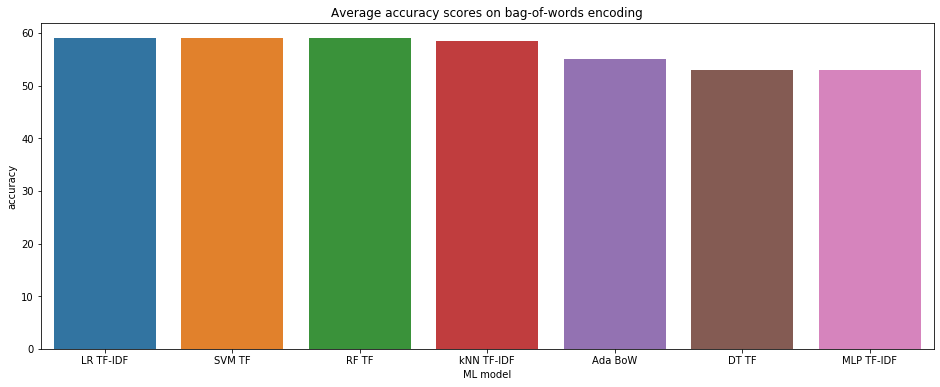

In [35]:
new_dict = {'LR TF-IDF': 59, 'SVM TF': 59, 'DT TF': 53, 'RF TF': 59, 
            'Ada BoW': 55, 'MLP TF-IDF': 53, 'kNN TF-IDF': 58.4}
new_dict = pd.DataFrame(index=new_dict.keys(), data=list(new_dict.values()), columns=['accuracy'])
new_dict = new_dict.sort_values('accuracy', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(data=new_dict, y='accuracy', x=new_dict.index)
plt.title('Average accuracy scores on bag-of-words encoding')
plt.xlabel('ML model')
plt.show()

From the Accuracy Results: 
Logistic Regression, Linear Support Vector Machines, and Random Forest achieve 59% average accuracy

#### Plotting Feature importance

In [36]:
# defining function that receives encoded data and plots bargraph
def plot_importance(X, title):  
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in X]
    plt.bar(x=X.index, height=X, color=colors)
    plt.xticks(rotation=60, ha='right')
    plt.title(title)
    plt.ylabel('Feature weight')
    plt.show()

In [37]:
# Running LR to determinate label
X = tf_idf()
y = label
clf = LogisticRegression(penalty='l2', dual=False, 
                         tol=0.0001, C=1, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, 
                         random_state=43, solver='liblinear', max_iter=100, 
                         multi_class='auto', verbose=0, warm_start=False, 
                         n_jobs=-1, l1_ratio=None)
clf.fit(X,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=43,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [38]:
# creating a dataframe with the classification of claims
LRf = pd.DataFrame() 
LRf['more false'] = pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(0, axis=1, ascending=False).columns[1:26]
LRf['less false'] = np.flip(pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(0, axis=1, ascending=False).columns[-25:])
LRf['more true'] = pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(2, axis=1, ascending=False).columns[0:25]
LRf['less true'] = np.flip(pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(2, axis=1, ascending=False).columns[-25:])
LRf

,more false,less false,more true,less true
0,claim,bush,photograph,obamacare
1,soros,texas,representative,billion
2,dead,percent,york,will
3,indian,accurately,mccain,russia
4,body,marriage,member,claim
5,arrest,georgia,gdp,report
6,actor,state,duty,order
7,muslim,average,launch,isi
8,singer,economy,legislator,claimed
9,pelosi,offender,request,medicare


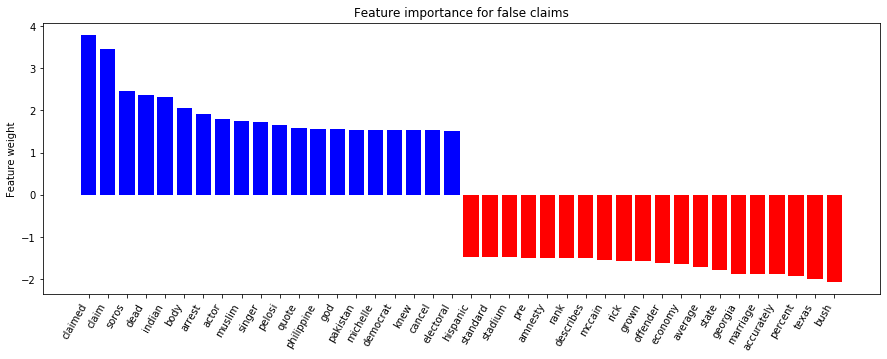

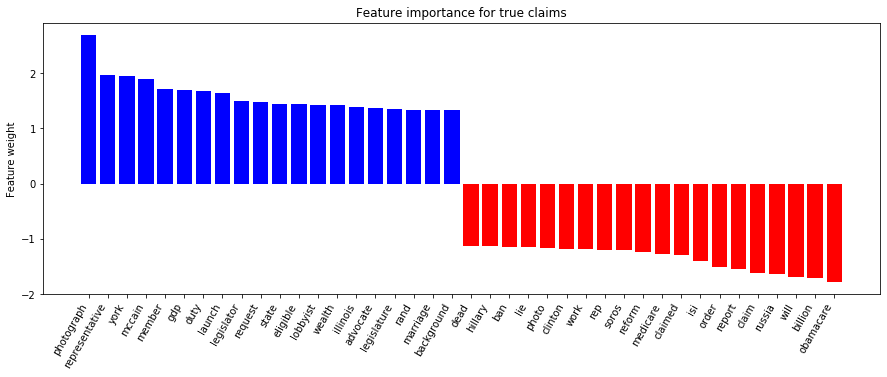

In [39]:
# Plotting the feature importance with 1-gram
f = 20
LRf = pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(0, axis=0, ascending=False).head(f)
LRf = LRf.append(pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(0, axis=0, ascending=False).tail(f))
plot_importance(LRf[0], 'Feature importance for false claims')

LRf = pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(2, axis=0, ascending=False).head(f)
LRf = LRf.append(pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(2, axis=0, ascending=False).tail(f))
plot_importance(LRf[2], 'Feature importance for true claims')

##### On weights of features (1 word):
LR assigns weights to each of the features. The features under study are single words, and the features shown are the ones having the largest and smallest weights. 

In [40]:
# Running LR to determinate label in the range from 4 to 7 words
X = tf_idf(min_g=4, max_g=7, min_count=2)
clf = LogisticRegression(penalty='l2', dual=False, 
                         tol=0.0001, C=1, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, 
                         random_state=43, solver='liblinear', max_iter=100, 
                         multi_class='auto', verbose=0, warm_start=False, 
                         n_jobs=-1, l1_ratio=None)
clf.fit(X,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=43,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
# creating a dataframe with the classification of claims
LRf = pd.DataFrame() 
LRf['more false'] = pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(0, axis=1, ascending=False).columns[0:25]
LRf['less false'] = np.flip(pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(0, axis=1, ascending=False).columns[-25:])
LRf['more true'] = pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(2, axis=1, ascending=False).columns[0:25]
LRf['less true'] = np.flip(pd.DataFrame(data=clf.coef_, columns=X.columns).sort_values(2, axis=1, ascending=False).columns[-25:])
LRf

,more false,less false,more true,less true
0,vice president mike penny,high school graduation rate,donald trump tax plan,october collect twitter october
1,russian president vladimir putin,abortion case rape incest,support expand background check,february collect twitter february
2,rep alexandria ocasio cortez,support universal background check,california large death row,rep alexandria ocasio cortez
3,true collect mail april,high corporate tax rate,year ago john mccain,july collect twitter july
4,example collect facebook october,paid family leave program,roy moore practice muslim,example collect facebook october
5,true collect email january,donald trump tax plan,parkland shoot survivor activist,collect mail twitter march
6,government takeover health care,gov rick scott cut,parkland florida school shoot,march collect twitter march
7,example collect facebook november,percent american people support,donald trump criticize president,september collect twitter september
8,dr christine blasey ford,special counsel robert mueller,barack obama percent vote,fbi director james comey
9,philippine president rodrigo duterte,pay high tax rate,wealth bottom percent american,secretary state hillary clinton


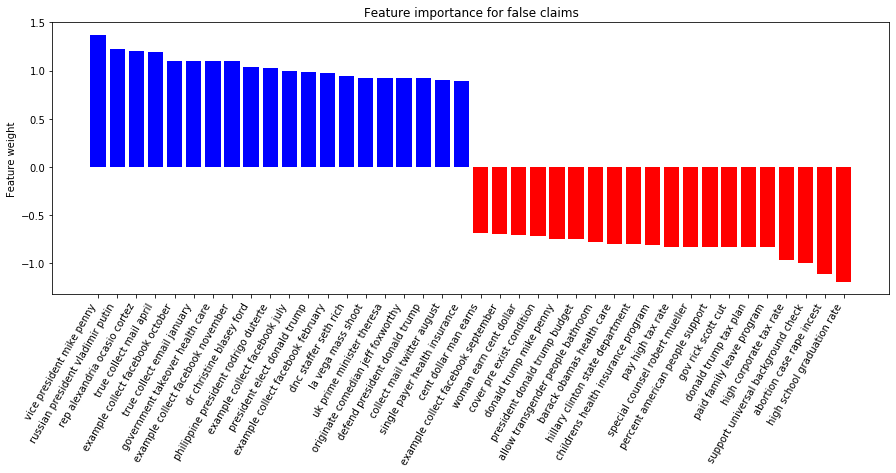

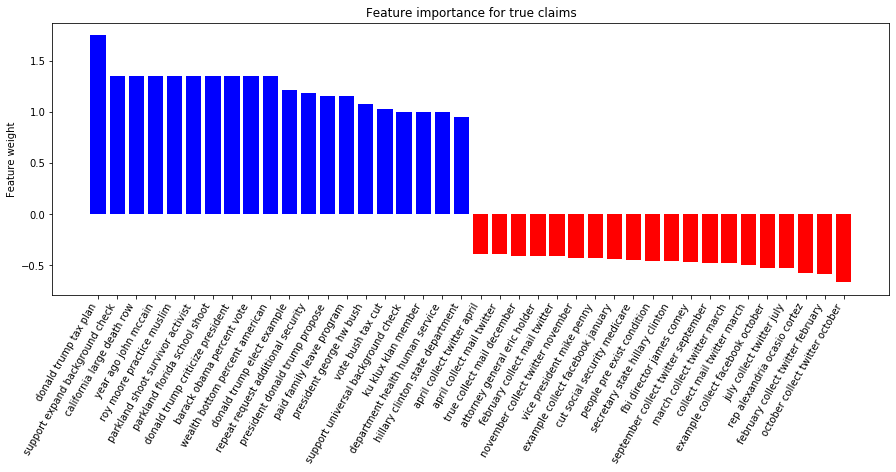

In [42]:
# Plotting the feature importance with 4-7grams
f = 20
LRf = pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(0, axis=0, ascending=False).head(f)
LRf = LRf.append(pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(0, axis=0, ascending=False).tail(f))
plot_importance(LRf[0], 'Feature importance for false claims')

LRf = pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(2, axis=0, ascending=False).head(f)
LRf = LRf.append(pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(2, axis=0, ascending=False).tail(f))
plot_importance(LRf[2], 'Feature importance for true claims')

In [43]:
# Running Linear SVC to determinate label in the range from 2 to 3 words
X = term_freq(min_g=2, max_g=3)
clf = LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.0001, C=5, 
                fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, 
                random_state=43, max_iter=1000)

clf.fit(X, y)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=43, tol=0.0001, verbose=0)

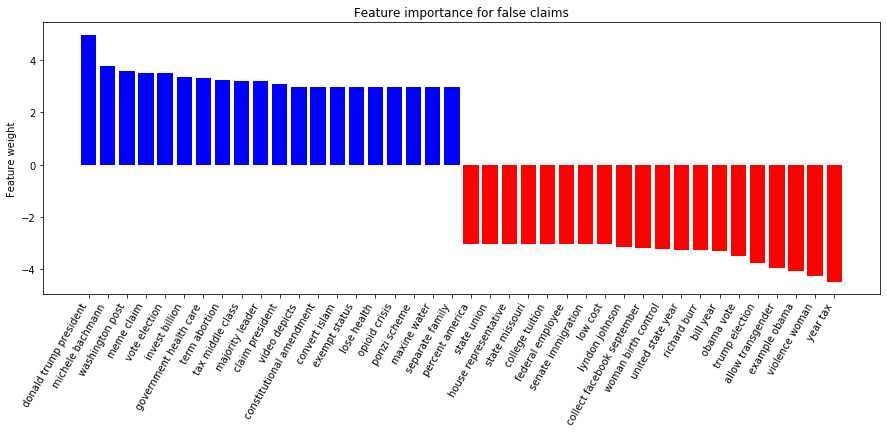

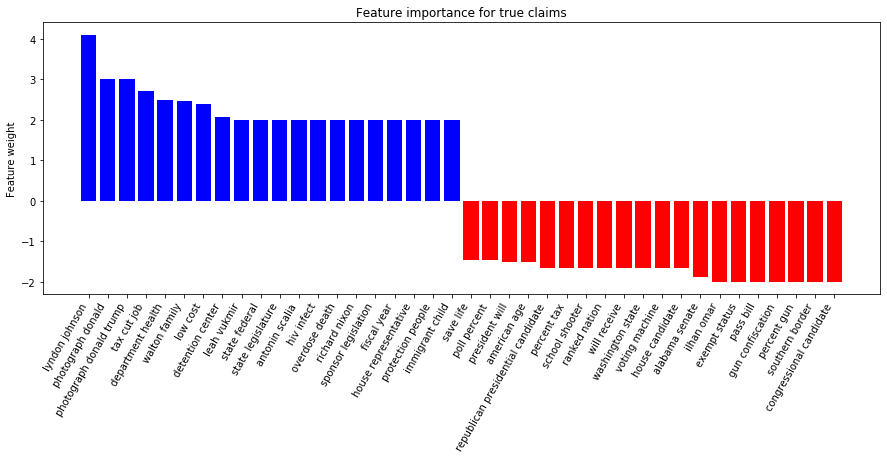

In [44]:
# Plotting the feature importance with 2-3grams
f = 20
LRf = pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(0, axis=0, ascending=False).head(f)
LRf = LRf.append(pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(0, axis=0, ascending=False).tail(f))
plot_importance(LRf[0], 'Feature importance for false claims')

LRf = pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(2, axis=0, ascending=False).head(f)
LRf = LRf.append(pd.DataFrame(data=np.transpose(clf.coef_), index=X.columns, columns=clf.classes_).sort_values(2, axis=0, ascending=False).tail(f))
plot_importance(LRf[2], 'Feature importance for true claims')

### Feature Importance according to Random Forest

In [45]:
X = term_freq(min_g=2, max_g=3)
clf_RF = RandomForestClassifier(n_estimators=40, criterion= 'entropy', 
         max_depth=None, min_samples_split=2, 
         min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
         max_features='log2', max_leaf_nodes=None, 
         min_impurity_decrease=0.0, min_impurity_split=None)
clf_RF.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
sf = pd.DataFrame(clf_RF.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', axis=0, ascending=False)

In [47]:
sf = sf.head(20)

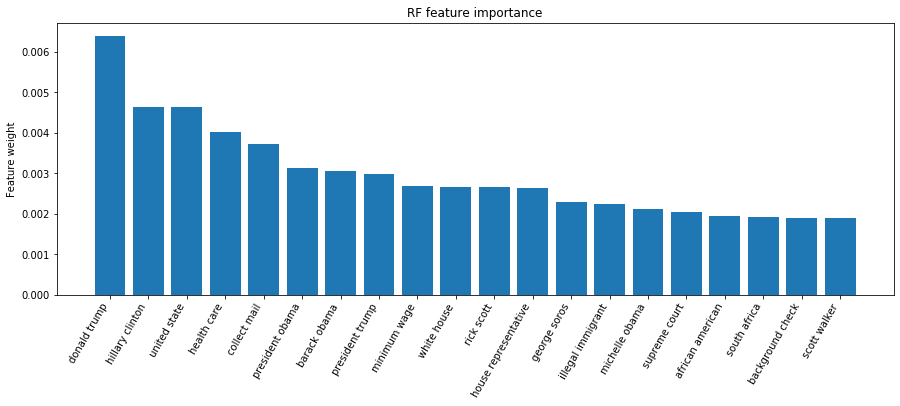

In [48]:
plt.figure(figsize=(15, 5))
plt.bar(x=sf.index, height=sf.importance)
plt.xticks(rotation=60, ha='right')
plt.title('RF feature importance')
plt.ylabel('Feature weight')
plt.show()

Random Forest feature importance: We can learn about the most frequently discussed topics.We see that the corpus was mostly extracted from the period of the last US elections, when many initiatives were active with regards to fact checking the claims of the candidates and news. 

### Proportion of label classifications (using LR model) 

In [49]:
from sklearn.metrics import confusion_matrix

X = tf_idf()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [50]:
clf = LogisticRegression(penalty='l2', dual=False, 
                         tol=0.0001, C=1, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, 
                         random_state=43, solver='liblinear', max_iter=100, 
                         multi_class='auto', verbose=0, warm_start=False, 
                         n_jobs=-1, l1_ratio=None)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [51]:
df = pd.DataFrame(data=y_test, columns=['y_test'])
df['y_pred'] = y_pred
# df[df['y_pred'] == 2]
print(accuracy_score(df['y_test'], df['y_pred'])*100)
df = pd.DataFrame(data=confusion_matrix(df['y_test'], df['y_pred']),
             index=np.unique(y_pred), columns=np.unique(y_pred))
df

58.93924783027965


,0,1,2
0,1804,678,5
1,882,1248,5
2,301,258,4


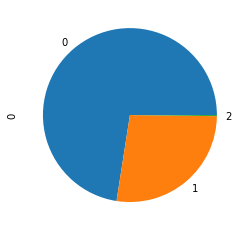

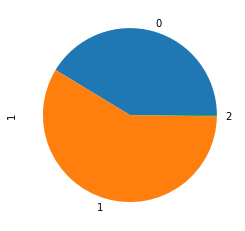

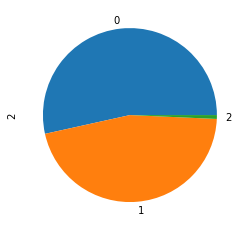

In [52]:
df.loc[0].plot.pie()
plt.show()
df.loc[1].plot.pie()
plt.show()
df.loc[2].plot.pie()
plt.show()

---